<a href="https://www.kaggle.com/code/yasinsoylu123/brain-tumor-classification?scriptVersionId=116571283" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle

import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [3]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 99.25it/s] 


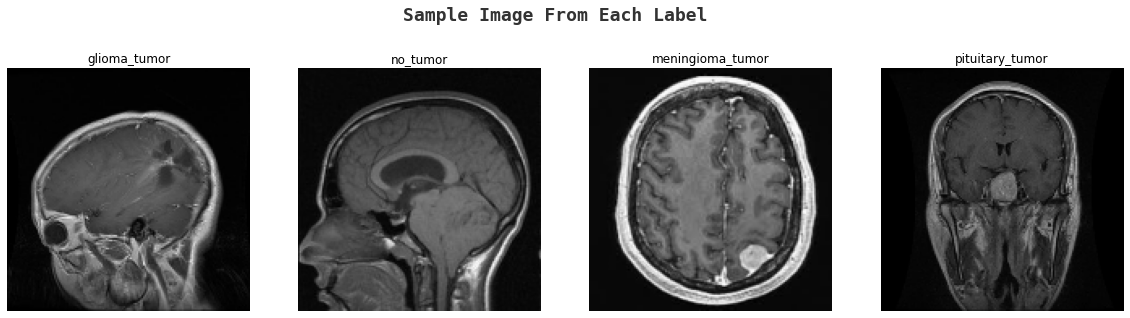

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)




In [8]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization()) 

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.35)) #64 --> 42

model.add(Conv2D(64, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512)) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(4)) 
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 64)        2

2023-01-17 07:46:29.378461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 07:46:29.481907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 07:46:29.482769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 07:46:29.484577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
batch_size=32
epochs = 50

In [10]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [11]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

2023-01-17 07:46:32.265454: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-17 07:46:32.265501: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-17 07:46:32.267345: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-17 07:46:32.490513: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-17 07:46:32.490788: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [12]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

2023-01-17 07:46:33.035321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-17 07:46:34.827736: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/83 [..............................] - ETA: 11:44 - loss: 1.7793 - accuracy: 0.3438

2023-01-17 07:46:41.699571: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-17 07:46:41.699627: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/83 [..............................] - ETA: 29s - loss: 2.6752 - accuracy: 0.3906  

2023-01-17 07:46:42.043472: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-17 07:46:42.044197: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-17 07:46:42.177726: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 256 callback api events and 253 activity events. 
2023-01-17 07:46:42.186816: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-17 07:46:42.203448: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2023_01_17_07_46_42

2023-01-17 07:46:42.209684: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_01_17_07_46_42/1da2e6a328f7.trace.json.gz
2023-01-17 07:46:42.233007: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

83/83 [==============================] - 14s 70ms/step - loss: 1.0576 - accuracy: 0.6776 - val_loss: 5.9197 - val_accuracy: 0.3061

Epoch 00001: val_accuracy improved from -inf to 0.30612, saving model to cnn.h5
Epoch 2/20
83/83 [==============================] - 5s 54ms/step - loss: 0.5734 - accuracy: 0.7753 - val_loss: 1.0088 - val_accuracy: 0.6633

Epoch 00002: val_accuracy improved from 0.30612 to 0.66327, saving model to cnn.h5
Epoch 3/20
83/83 [==============================] - 5s 54ms/step - loss: 0.3960 - accuracy: 0.8521 - val_loss: 0.5461 - val_accuracy: 0.8265

Epoch 00003: val_accuracy improved from 0.66327 to 0.82653, saving model to cnn.h5
Epoch 4/20
83/83 [==============================] - 5s 55ms/step - loss: 0.2878 - accuracy: 0.8880 - val_loss: 0.5909 - val_accuracy: 0.8231

Epoch 00004: val_accuracy did not improve from 0.82653
Epoch 5/20
83/83 [==============================] - 5s 54ms/step - loss: 0.2307 - accuracy: 0.9205 - val_loss: 0.3353 - val_accuracy: 0.8878


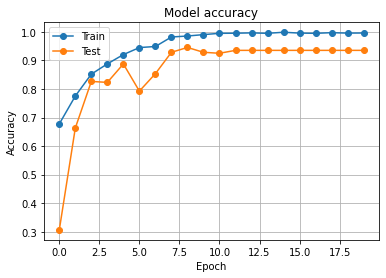

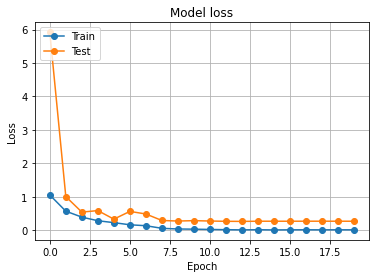

In [13]:
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# EfficientNetB0

In [14]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


In [15]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [18]:
history = model.fit(X_train, y_train, batch_size = 64, validation_data = (X_test, y_test),
                     epochs = 20, callbacks =[callbacks] )

Epoch 1/20
46/46 [==============================] - 20s 253ms/step - loss: 0.4118 - accuracy: 0.8458 - val_loss: 0.2707 - val_accuracy: 0.9174
Epoch 2/20
46/46 [==============================] - 10s 213ms/step - loss: 0.1537 - accuracy: 0.9462 - val_loss: 0.4458 - val_accuracy: 0.8532
Epoch 3/20
46/46 [==============================] - 10s 211ms/step - loss: 0.0761 - accuracy: 0.9765 - val_loss: 0.2665 - val_accuracy: 0.9297
Epoch 4/20
46/46 [==============================] - 10s 212ms/step - loss: 0.0626 - accuracy: 0.9816 - val_loss: 0.1398 - val_accuracy: 0.9602
Epoch 5/20
46/46 [==============================] - 10s 210ms/step - loss: 0.0407 - accuracy: 0.9864 - val_loss: 0.1895 - val_accuracy: 0.9541
Epoch 6/20
46/46 [==============================] - 10s 210ms/step - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.2739 - val_accuracy: 0.9480
Epoch 7/20
46/46 [==============================] - 10s 213ms/step - loss: 0.0227 - accuracy: 0.9915 - val_loss: 0.4080 - val_accuracy: 0.8991

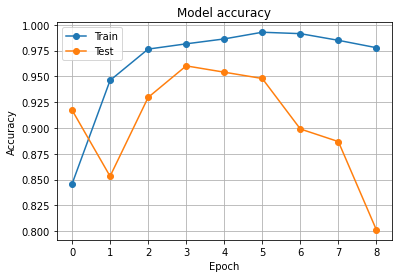

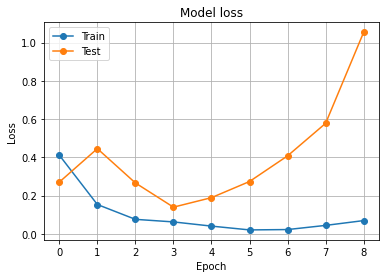

In [19]:
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

# vgg16

In [20]:
vgg_model=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False,pooling="max")


58900480/58889256 [==============================] - 0s 0us/step


In [21]:
for layer in vgg_model.layers:
    layer.trainable  = False

In [22]:
model = Sequential()
model.add(vgg_model)

model.add(Flatten()) 
model.add(Activation('relu'))
Dropout(rate=0.5)
model.add(Dense(4)) 
model.add(Activation('softmax'))



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_8 (Activation)    (None, 4)                 0         
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [24]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

2023-01-17 07:51:29.402335: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-17 07:51:29.402380: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-17 07:51:29.642731: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-17 07:51:29.642936: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [25]:
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test),
                    steps_per_epoch = len(X_train) / batch_size, epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
 2/91 [..............................] - ETA: 18s - loss: 25.2197 - accuracy: 0.1719 

2023-01-17 07:51:32.119763: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-17 07:51:32.119811: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 3/91 [..............................] - ETA: 46s - loss: 23.0757 - accuracy: 0.1979

2023-01-17 07:51:32.958808: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-17 07:51:32.959574: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-17 07:51:33.090904: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 125 callback api events and 122 activity events. 
2023-01-17 07:51:33.095639: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-17 07:51:33.100477: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2023_01_17_07_51_33

2023-01-17 07:51:33.103442: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_01_17_07_51_33/1da2e6a328f7.trace.json.gz
2023-01-17 07:51:33.111522: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

91/91 [==============================] - 8s 67ms/step - loss: 9.9836 - accuracy: 0.4784 - val_loss: 6.6787 - val_accuracy: 0.5810

Epoch 00001: val_accuracy improved from -inf to 0.58104, saving model to effnet.h5
Epoch 2/20
91/91 [==============================] - 4s 40ms/step - loss: 4.6484 - accuracy: 0.6629 - val_loss: 4.3587 - val_accuracy: 0.6483

Epoch 00002: val_accuracy improved from 0.58104 to 0.64832, saving model to effnet.h5
Epoch 3/20
91/91 [==============================] - 3s 37ms/step - loss: 3.1557 - accuracy: 0.7249 - val_loss: 3.5154 - val_accuracy: 0.7034

Epoch 00003: val_accuracy improved from 0.64832 to 0.70336, saving model to effnet.h5
Epoch 4/20
91/91 [==============================] - 3s 37ms/step - loss: 2.2593 - accuracy: 0.7657 - val_loss: 2.8508 - val_accuracy: 0.7401

Epoch 00004: val_accuracy improved from 0.70336 to 0.74006, saving model to effnet.h5
Epoch 5/20
91/91 [==============================] - 4s 40ms/step - loss: 1.8385 - accuracy: 0.7909 - v

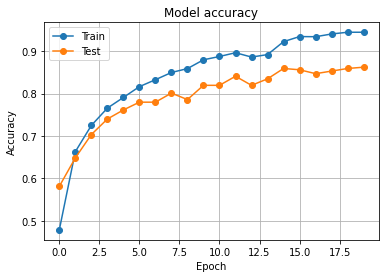

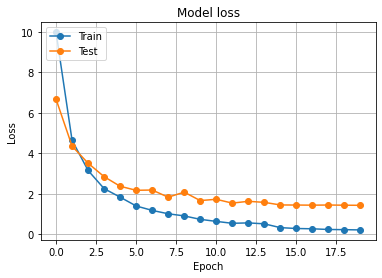

In [26]:
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

In [27]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.87      0.82      0.84        93
           1       0.82      0.90      0.86        51
           2       0.85      0.84      0.85        96
           3       0.89      0.91      0.90        87

    accuracy                           0.86       327
   macro avg       0.86      0.87      0.86       327
weighted avg       0.86      0.86      0.86       327



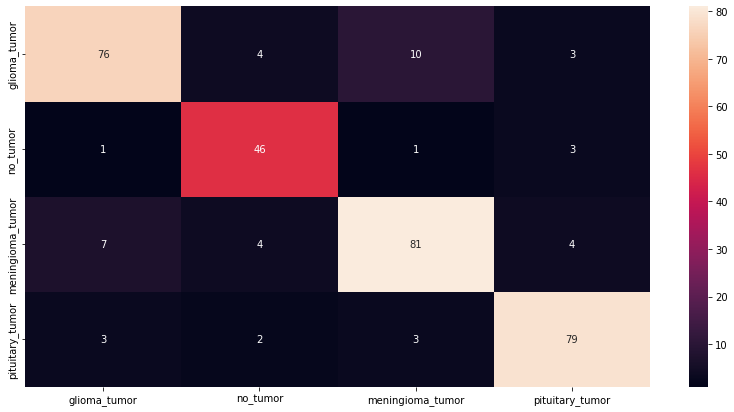

In [29]:
from sklearn.metrics import confusion_matrix

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)


plt.show()

In [30]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [31]:
import ipywidgets as widgets

uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [32]:
from IPython.display import display,clear_output

button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])